In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
# Time Series
from statsmodels.tsa.arima.model import ARIMA

In [5]:
# Fetch financial data
import yfinance as yf
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
# Fetch historical Nifty50 data from Yahoo Finance
# You can change the ticker here if you want any other stock/index
nifty = yf.download("^NSEI", start="2018-01-01", end="2026-01-01")
# Save as CSV (optional, good for backup)
nifty.to_csv("nifty50_data.csv")
# Display first 5 rows
nifty.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2018-01-02,10442.200195,10495.200195,10404.650391,10477.549805,153400
2018-01-03,10443.200195,10503.599609,10429.549805,10482.650391,167300
2018-01-04,10504.799805,10513.000000,10441.450195,10469.400391,174900
2018-01-05,10558.849609,10566.099609,10520.099609,10534.250000,180900
2018-01-08,10623.599609,10631.200195,10588.549805,10591.700195,169000


In [7]:
# Calculate daily returns
nifty['Returns'] = nifty['Close'].pct_change()
# Calculate rolling volatility (30-day window)
nifty['Volatility'] = nifty['Returns'].rolling(window=30).std()
# Moving averages
nifty['MA_10'] = nifty['Close'].rolling(window=10).mean()
nifty['MA_30'] = nifty['Close'].rolling(window=30).mean()
# Lag features
nifty['Vol_Lag1'] = nifty['Volatility'].shift(1)
nifty['Vol_Lag2'] = nifty['Volatility'].shift(2)
# Drop NaN rows generated due to rolling calculations
nifty = nifty.dropna()
nifty.head()

Price,Close,High,Low,Open,Volume,Returns,Volatility,MA_10,MA_30,Vol_Lag1,Vol_Lag2
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,
Date,,,,,,,,,,,
2018-02-19,10378.400391,10489.349609,10302.750000,10488.900391,187300,-0.007070,0.007909,10509.015039,10733.576725,0.007885,0.007704
2018-02-20,10360.400391,10429.349609,10347.650391,10391.000000,187700,-0.001734,0.007843,10478.400098,10726.961751,0.007909,0.007885
2018-02-21,10397.450195,10426.099609,10349.599609,10426.000000,234100,0.003576,0.007781,10468.320117,10719.423437,0.007843,0.007909
2018-02-22,10382.700195,10397.549805,10340.650391,10354.349609,313600,-0.001419,0.007773,10458.920117,10710.946777,0.007781,0.007843
2018-02-23,10491.049805,10499.099609,10396.650391,10408.099609,210600,0.010436,0.008038,10450.340137,10706.241764,0.007773,0.007781


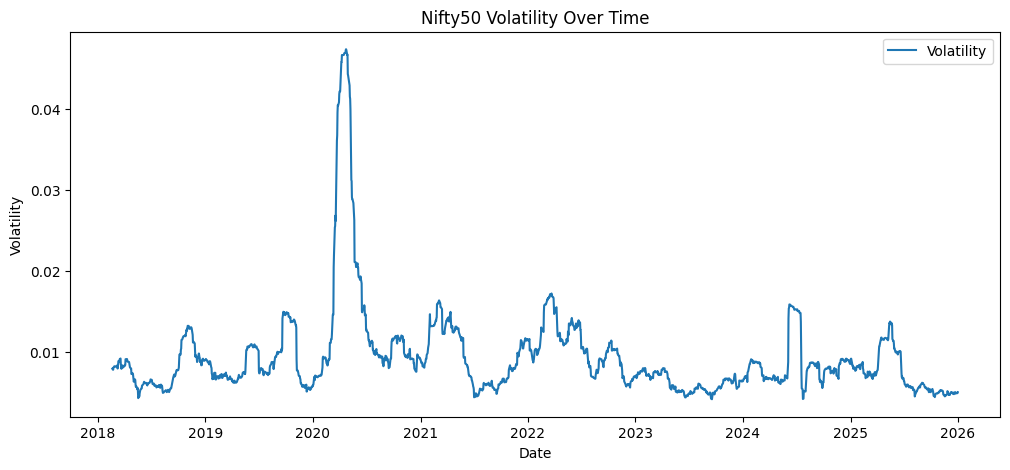

In [8]:
# Visualize Volatility
plt.figure(figsize=(12,5))
plt.plot(nifty.index, nifty['Volatility'], label='Volatility')
plt.title("Nifty50 Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [9]:
# Use chronological split
train = nifty[:'2024-12-31']
test = nifty['2025-01-01':]

# Features and target
features = ['MA_10', 'MA_30', 'Vol_Lag1', 'Vol_Lag2']
X_train = train[features]
y_train = train['Volatility']
X_test = test[features]
y_test = test['Volatility']
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1691, 4)
Test shape: (249, 4)


In [11]:
# Initialize and train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Predict
rf_preds = rf.predict(X_test)
# Evaluation (updated for all scikit-learn versions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest RMSE: {rf_rmse:.6f}")
print(f"Random Forest MAE: {rf_mae:.6f}")

Random Forest RMSE: 0.000790
Random Forest MAE: 0.000464


In [12]:
# Train ARIMA on training volatility series
arima_model = ARIMA(train['Volatility'], order=(5,1,0))
arima_fit = arima_model.fit()
# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))
# Evaluation (RMSE calculated manually)
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
arima_mae = mean_absolute_error(y_test, arima_forecast)
print(f"ARIMA RMSE: {arima_rmse:.6f}")
print(f"ARIMA MAE: {arima_mae:.6f}")

ARIMA RMSE: 0.002702
ARIMA MAE: 0.002386


In [13]:
# Create a summary DataFrame
forecast_df = pd.DataFrame({
    "Date": y_test.index,
    "Actual_Volatility": y_test.values,
    "RF_Predicted_Volatility": rf_preds,
    "ARIMA_Predicted_Volatility": arima_forecast
})
# Add a simple business risk flag based on RF prediction
# Example threshold: Volatility > 0.02 → High Risk
forecast_df['Risk_Flag'] = np.where(forecast_df['RF_Predicted_Volatility'] > 0.02, "High Risk", "Normal")
# Display the first 20 rows
forecast_df.head(20)

,Date,Actual_Volatility,RF_Predicted_Volatility,ARIMA_Predicted_Volatility,Risk_Flag
1691,2025-01-01,0.008499,0.008529,0.008451,Normal
1692,2025-01-02,0.009129,0.008616,0.008419,Normal
1693,2025-01-03,0.009143,0.009056,0.008392,Normal
1694,2025-01-06,0.008591,0.009129,0.008371,Normal
1695,2025-01-07,0.008247,0.008578,0.008360,Normal
1696,2025-01-08,0.008246,0.008339,0.008351,Normal
1697,2025-01-09,0.008286,0.008323,0.008345,Normal
1698,2025-01-10,0.007888,0.008313,0.008341,Normal
1699,2025-01-13,0.008072,0.008031,0.008338,Normal
1700,2025-01-14,0.008014,0.008127,0.008335,Normal


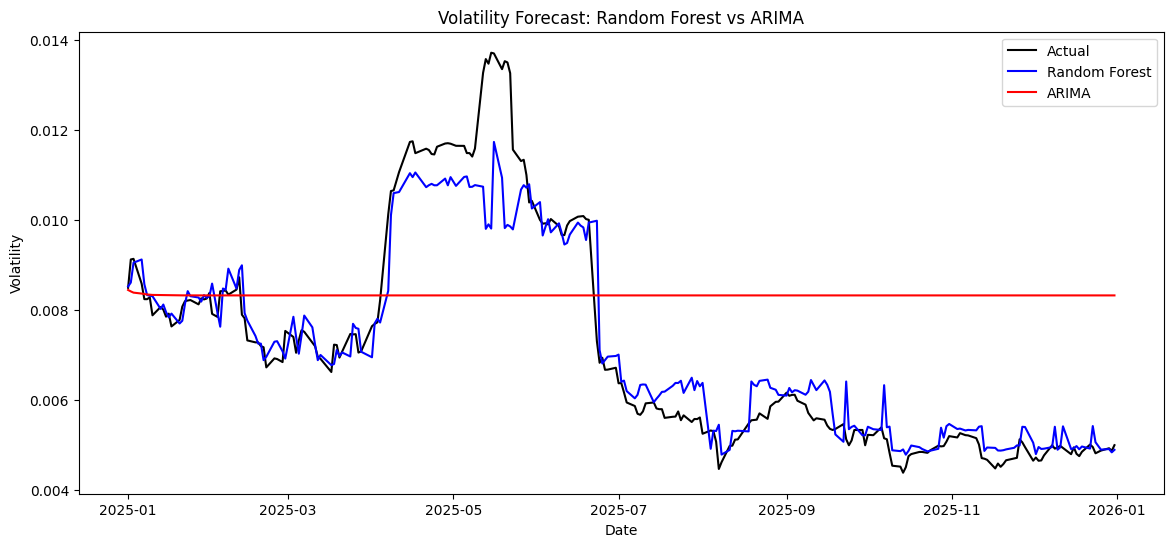

In [14]:
plt.figure(figsize=(14,6))
plt.plot(forecast_df['Date'], forecast_df['Actual_Volatility'], label='Actual', color='black')
plt.plot(forecast_df['Date'], forecast_df['RF_Predicted_Volatility'], label='Random Forest', color='blue')
plt.plot(forecast_df['Date'], forecast_df['ARIMA_Predicted_Volatility'], label='ARIMA', color='red')
plt.title("Volatility Forecast: Random Forest vs ARIMA")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [15]:
import sqlite3

# Connect to (or create) a local SQLite database
conn = sqlite3.connect("financial_risk_forecast.db")
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS nifty_volatility_forecast (
    Date TEXT PRIMARY KEY,
    Actual_Volatility REAL,
    RF_Predicted_Volatility REAL,
    ARIMA_Predicted_Volatility REAL,
    Risk_Flag TEXT
)
""")

# Insert data from forecast_df into the table
forecast_df.to_sql("nifty_volatility_forecast", conn, if_exists='replace', index=False)
# Commit changes and close connection
conn.commit()
conn.close()
print("Forecast data successfully saved to SQLite database: financial_risk_forecast.db")

Forecast data successfully saved to SQLite database: financial_risk_forecast.db


In [16]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("financial_risk_forecast.db")

# Query all data
df_sql = pd.read_sql("SELECT * FROM nifty_volatility_forecast", conn)

# Close connection
conn.close()

# Convert 'Date' column to datetime
df_sql['Date'] = pd.to_datetime(df_sql['Date'])

# Display first 10 rows
df_sql.head(10)

,Date,Actual_Volatility,RF_Predicted_Volatility,ARIMA_Predicted_Volatility,Risk_Flag
0,2025-01-01,0.008499,0.008529,0.008451,Normal
1,2025-01-02,0.009129,0.008616,0.008419,Normal
2,2025-01-03,0.009143,0.009056,0.008392,Normal
3,2025-01-06,0.008591,0.009129,0.008371,Normal
4,2025-01-07,0.008247,0.008578,0.008360,Normal
5,2025-01-08,0.008246,0.008339,0.008351,Normal
6,2025-01-09,0.008286,0.008323,0.008345,Normal
7,2025-01-10,0.007888,0.008313,0.008341,Normal
8,2025-01-13,0.008072,0.008031,0.008338,Normal
9,2025-01-14,0.008014,0.008127,0.008335,Normal


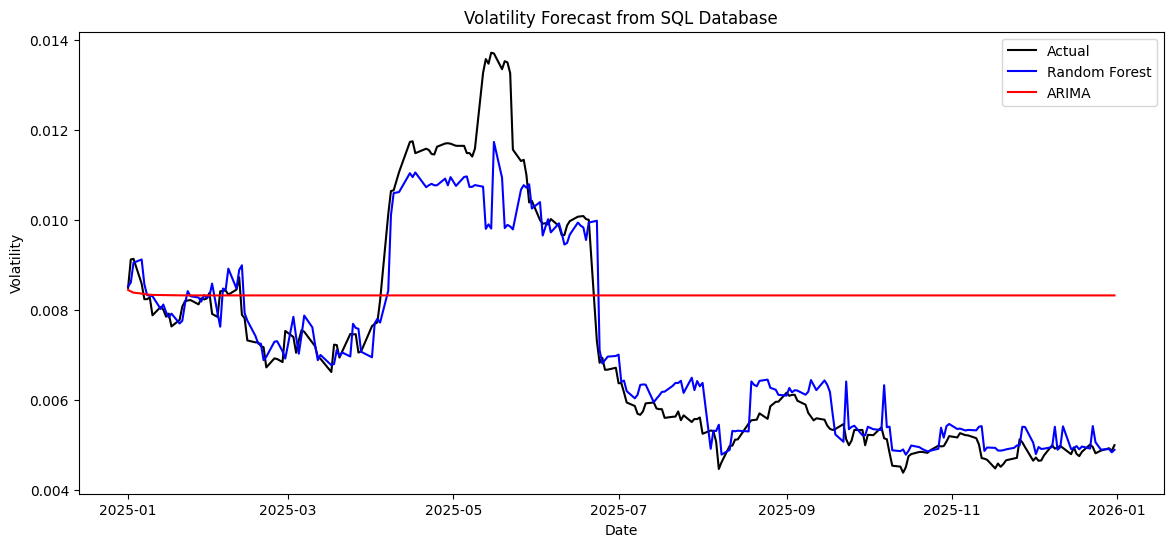

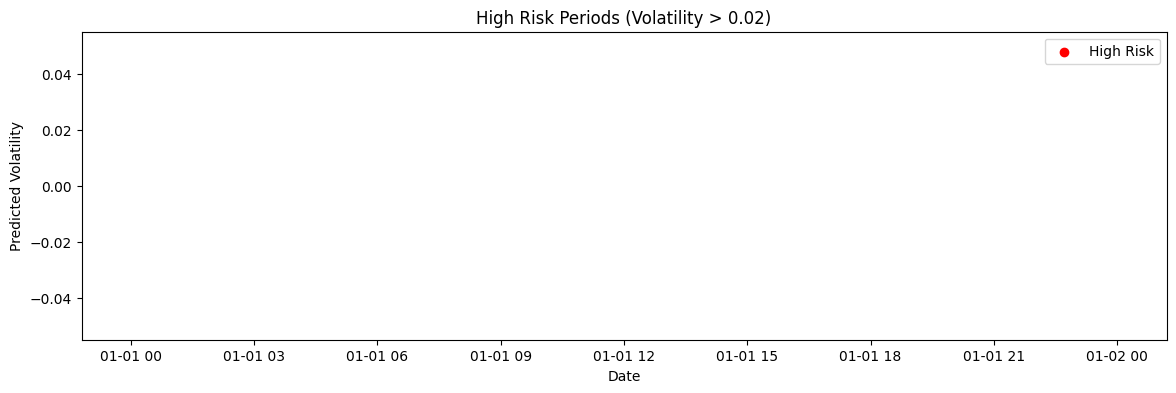

In [17]:
plt.figure(figsize=(14,6))
plt.plot(df_sql['Date'], df_sql['Actual_Volatility'], label='Actual', color='black')
plt.plot(df_sql['Date'], df_sql['RF_Predicted_Volatility'], label='Random Forest', color='blue')
plt.plot(df_sql['Date'], df_sql['ARIMA_Predicted_Volatility'], label='ARIMA', color='red')
plt.title("Volatility Forecast from SQL Database")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Highlight High Risk periods in a scatter plot
high_risk = df_sql[df_sql['Risk_Flag'] == "High Risk"]
plt.figure(figsize=(14,4))
plt.scatter(high_risk['Date'], high_risk['RF_Predicted_Volatility'], color='red', label='High Risk')
plt.title("High Risk Periods (Volatility > 0.02)")
plt.xlabel("Date")
plt.ylabel("Predicted Volatility")
plt.legend()
plt.show()